In [73]:
import matplotlib
font = {'size' : 11}
matplotlib.rc('font', **font)

import numpy as np
from scipy.interpolate import PchipInterpolator
from scipy.integrate import cumulative_simpson
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator



In [74]:
wlwn = lambda x: 1.0e7/(x-1.0e-50)

In [75]:
def ncdf_spec(ds):

    out = {}

    # bin edges [nm]
    soc_wl_up = ds["bandmax"][:] * 1e9
    soc_wl_lo = ds["bandmin"][:] * 1e9

    # bin edges [cm-1]
    soc_wn_lo = np.array(wlwn(soc_wl_up))
    soc_wn_up = np.array(wlwn(soc_wl_lo))

    # bin widths [cm-1]
    soc_wn_w = soc_wn_up - soc_wn_lo

    # bin centres [cm-1]
    soc_wn_c = 0.5*(soc_wn_up + soc_wn_lo)

    # get flux
    idx = 0
    soc_fl = np.array(ds["ba_U_LW"][idx,:]) # + ds["ba_U_SW"][idx,:] # W m-2
    soc_fl *= 1e3       # erg s-1 cm-2
    soc_fl /= soc_wn_w  # erg s-1 cm-2 /(cm-1)

    # convert to ascending order of wavenumber
    if soc_wn_c[21] < soc_wn_c[20]:
        soc_fl   = soc_fl[::-1]
        soc_wn_c = soc_wn_c[::-1]

    out["soc_wn"] = soc_wn_c
    out["soc_fl"] = soc_fl

    # RFM data
    out["rfm_wn"] = ds["rfm_wn"][:]
    out["rfm_fl"] = ds["rfm_fl"][:]

    return out

In [76]:
def resid_spec(wl,fl, wl_ref, fl_ref):

    ref_itp = PchipInterpolator(wl_ref, fl_ref)
    tst_itp = PchipInterpolator(wl, fl)

    x_eval = np.linspace(wl_ref[0], wl_ref[-1], 100)

    eval_r = (tst_itp(x_eval) - ref_itp(x_eval))
    return x_eval, eval_r

In [77]:
def integ_spec(wl,fl, wlmin, wlmax):

    imin = np.argmin(np.abs(wl-wlmin))
    imax = np.argmin(np.abs(wl-wlmax))

    _wl = wl[imin:imax]
    _fl = fl[imin:imax]

    _cu = cumulative_simpson(_fl, x=_wl, initial=0.0)

    return _wl, _cu

In [78]:
dat_ro = ncdf_spec(nc.Dataset("../out/ro/atm.nc"))
dat_ee = ncdf_spec(nc.Dataset("../out/ee/atm.nc"))

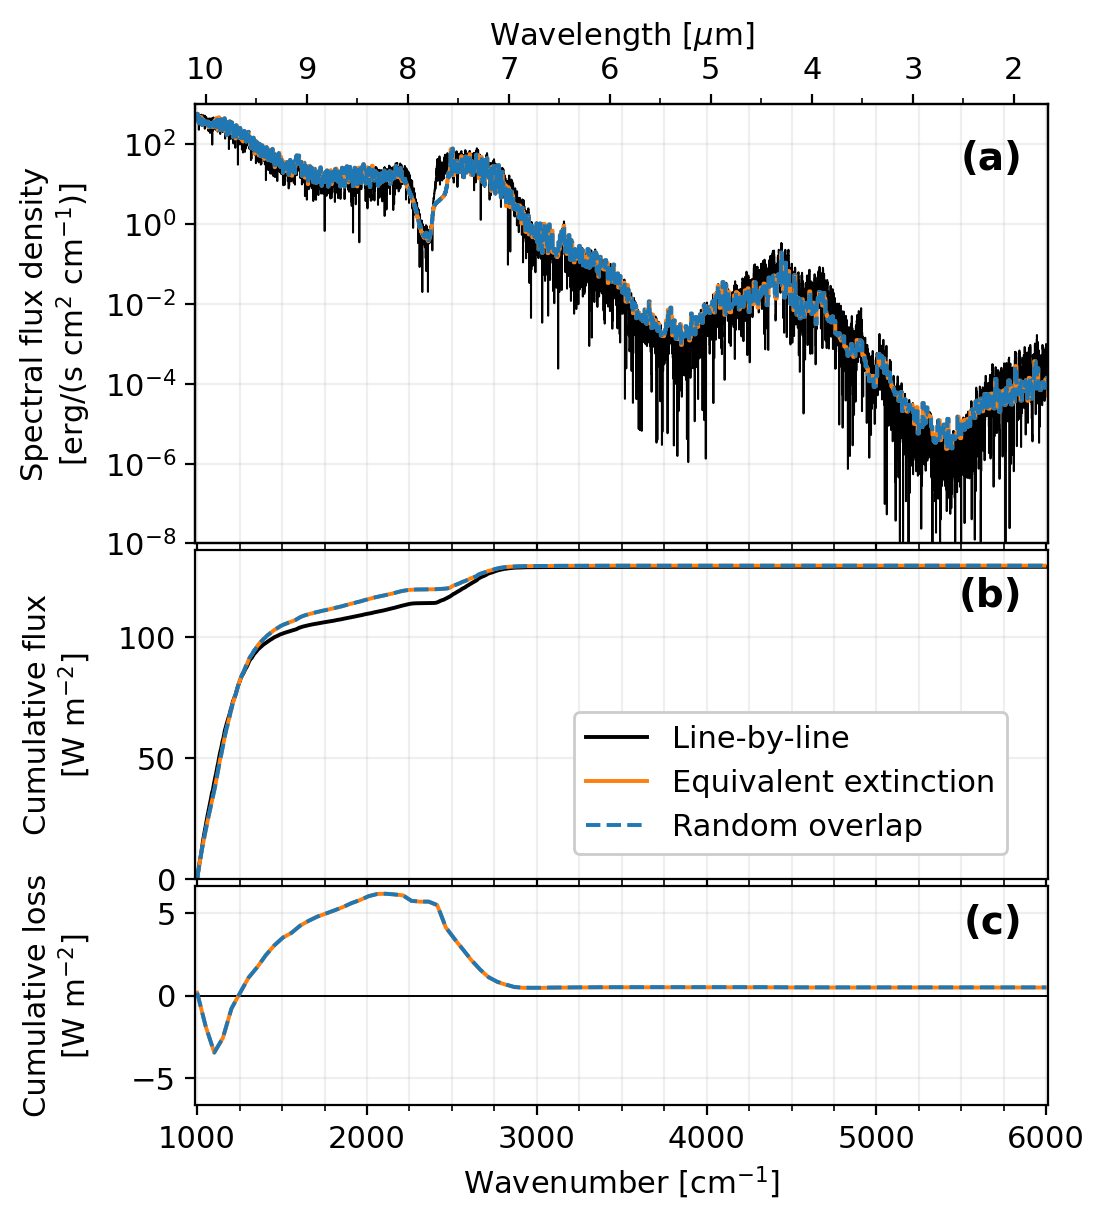

In [89]:
fig,axs = plt.subplots(3,1, figsize=(5.5,6.5), sharex=True, height_ratios=(4,3,2))
(ax0, ax1, ax2) = axs

lw = 1.4

# get wn and fl arrays
x_lbl, y_lbl = dat_ee["rfm_wn"], dat_ee["rfm_fl"]
x_ee,  y_ee  = dat_ee["soc_wn"], dat_ee["soc_fl"]
x_ro,  y_ro  = dat_ro["soc_wn"], dat_ro["soc_fl"]

wnmin = np.amin(x_lbl)
wnmax = np.amax(x_lbl)
x_lbl_c, y_lbl_c = integ_spec(x_lbl, y_lbl/1e3, wnmin, wnmax)

# lbl
c = 'black'
ax0.step(x_lbl,  y_lbl,   where='mid', color=c, lw=lw/2)
ax1.plot(x_lbl_c,y_lbl_c, color=c, lw=lw, label="Line-by-line")
ax2.axhline(y=0, color=c, lw=lw/2)

# ee
c = "tab:orange"
ax0.step(x_ee,y_ee, where='mid', color=c, lw=lw)
x, y = integ_spec(x_ee, y_ee/1e3, wnmin, wnmax)
ax1.plot(x,y, color=c, lw=lw, label="Equivalent extinction")
x, y = resid_spec(x, y, x_lbl_c, y_lbl_c)
ax2.plot(x,y, color=c, lw=lw)

# ro
c = "tab:blue"
ax0.step(x_ro, y_ro, where='mid', color=c,  lw=lw, ls='dashed')
x, y = integ_spec(x_ro, y_ro/1e3, wnmin, wnmax)
ax1.plot(x,y, color=c, lw=lw, ls='dashed', label="Random overlap")
x, y = resid_spec(x, y, x_lbl_c, y_lbl_c)
ax2.plot(x,y, color=c, lw=lw, ls='dashed')

# decorate top plot
ax0.set_yscale("log")
ax0.set_ylabel("Spectral flux density\n"+r"[erg/(s cm$^2$ cm$^{-1}$)]")
ax0.set_ylim(bottom=1e-8, top=1e3)

# decorate mid plot
ax1.set_ylabel("Cumulative flux\n"+r"[W m$^{-2}$]")
ax1.set_ylim(bottom=0)

# decorate bot plot
ax2.set_ylabel("Cumulative loss\n"+r"[W m$^{-2}$]")
ylim = np.amax(np.abs(ax2.get_ylim()))
ax2.set_ylim(-ylim, ylim)

xmin = np.amin(dat_ee["rfm_wn"])-10
xmax = np.amax(dat_ee["rfm_wn"])+10
ax2.set_xlim(left=xmin, right=xmax)
ax2.set_xlabel(r"Wavenumber [cm$^{-1}$]")
ax2.xaxis.set_major_locator(MultipleLocator(1000))
ax2.xaxis.set_minor_locator(MultipleLocator(250))

# dummy extra axis for wavelength units
axe = ax0.twiny()
axe.set_xlim(left=wlwn(xmin)/1e3, right=wlwn(xmax)/1e3)
axe.set_xlabel(r"Wavelength [$\mu$m]")
axe.xaxis.set_major_locator(MultipleLocator(1))
axe.xaxis.set_minor_locator(MultipleLocator(0.5))

ax1.legend(framealpha=1, loc='lower right', bbox_to_anchor=(0.97, 0.03))
for (ax,al) in zip(axs, 'abc'):
    ax.grid(zorder=-2, alpha=0.2, which='both')
    ax.text(0.97, 0.92, f"({al})", fontsize=14, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

fig.subplots_adjust(hspace=0.02)
fig.align_ylabels()

plt.show()
fig.savefig("nogit_lbl.pdf", bbox_inches='tight')